In [1]:
#coding:utf-8

In [2]:
# 跟「繪圖」有關的套件，如果沒有打算繪圖就不用 import
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.utils import shuffle
drive.mount('/content/drive')
import math
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Input, LSTM, Dropout
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def show_train_history(train_history):

  fig , ax = plt.subplots()
  fig.subplots_adjust(hspace=0.4, wspace=0.4) #設定子圖的間隔
  fig.set_figwidth(14)

  ax1 = plt.subplot(1, 2, 1)
  plt.title("Accuracy")
  plt.plot(train_history.history['accuracy'],'-', label='accuracy')
  plt.plot(train_history.history['val_accuracy'],'-',  label='val_accuracy')
  leg = ax1.legend(loc='lower right') 
  plt.ylabel('accuracy')
  plt.xlabel('Epoch')


  ax2 = plt.subplot(1, 2, 2)
  plt.title("Loss")
  plt.plot(train_history.history['loss'],'-', label='loss')
  plt.plot(train_history.history['val_loss'],'-', label='val_loss')
  leg = ax2.legend(loc='upper right') 
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.show()

In [4]:
data = pd.read_csv("/content/drive/MyDrive/EE深度學習/name,outline,totalFundedUSD.csv")
data = data.drop('country_code', axis=1)
data = data.drop('funding_rounds', axis=1)
data = data.drop('status', axis=1)
data = data.drop('entity_id', axis=1)
data = data.drop('normalized_name', axis=1)
data = data.dropna()

def isFunded(x):
  if (x == 0):
    return 0
  else:
    return 1

data['getFund'] = data['funding_total_usd'].apply(lambda x: isFunded(x))
data['notGetFund'] = data['funding_total_usd'].apply(lambda x: int(not isFunded(x)))
trainfundingTotalUsd = data[['getFund', 'notGetFund']].to_numpy()
trainOverviewString = data['overview'].to_numpy()
print(trainfundingTotalUsd.shape)
print(trainOverviewString.shape)


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(235235, 2)
(235235,)


In [5]:
# 非必要，但用了會比較快
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(" Number of GPUs available: " , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

 Number of GPUs available:  1


In [6]:
tokenizer = Tokenizer(lower=True, num_words=40000)
tokenizer.fit_on_texts(trainOverviewString)

In [7]:
trainOverviewString = tokenizer.texts_to_sequences(trainOverviewString)
print(trainOverviewString[20909])

[3580, 2064, 690, 19, 3, 3580, 32, 1, 80, 27, 247, 4, 321, 25, 24, 135, 2, 27, 434, 6, 3580, 2, 19, 695, 4, 6858, 321, 3580, 2064, 690, 16, 288, 46, 74, 9, 46, 996, 1549, 47, 1, 67, 24, 830, 2322, 9, 44, 28, 26, 137, 818, 12, 120, 25, 1191, 7742, 4, 120, 8, 26, 103]


In [8]:
trainOverviewString = pad_sequences(trainOverviewString, padding='post', maxlen=100)
print(trainOverviewString[10])
print(trainOverviewString.shape)

[    7     5    44 16552  1244     9   184    50   432  8700  1678    14
 16552    21   196    97   184   162  1305  3506    66  4019  1305  7350
  1305     1  1305  2946     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
(235235, 100)


In [9]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

348189


In [10]:
model = Sequential([
  Embedding(input_dim=40000, output_dim=16, mask_zero=True),
  LSTM(256),
  Dropout(0.2),
  Dense(512, activation='relu'),
  Dropout(0.2),
  Dense(256, activation='relu'),
  Dropout(0.2),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          640000    
                                                                 
 lstm (LSTM)                 (None, 256)               279552    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [12]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001, decay=0.0001), metrics=['accuracy'])

In [13]:
trainOverviewString, trainfundingTotalUsd = shuffle(trainOverviewString, trainfundingTotalUsd)
print(trainOverviewString)
print(trainfundingTotalUsd)

[[26741 32189     7 ...     0     0     0]
 [21428  9405     7 ...     0     0     0]
 [   84     3    94 ...     1  1596  1067]
 ...
 [  321  2962   423 ...     0     0     0]
 [   56    58  1669 ...     0     0     0]
 [    1   154   784 ...   224    21  1857]]
[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [14]:
print(trainOverviewString.shape)
print(trainfundingTotalUsd.shape)
train_history = model.fit(trainOverviewString, trainfundingTotalUsd, validation_split=0.2, epochs=10, batch_size=250)

(235235, 100)
(235235, 2)
Epoch 1/10
753/753 [==============================] - 72s 89ms/step - loss: 0.4856 - accuracy: 0.8800 - val_loss: 0.3827 - val_accuracy: 0.8837
Epoch 2/10
753/753 [==============================] - 64s 85ms/step - loss: 0.3772 - accuracy: 0.8825 - val_loss: 0.3511 - val_accuracy: 0.8837
Epoch 3/10
753/753 [==============================] - 64s 85ms/step - loss: 0.3266 - accuracy: 0.8825 - val_loss: 0.2836 - val_accuracy: 0.8837
Epoch 4/10
753/753 [==============================] - 67s 89ms/step - loss: 0.2822 - accuracy: 0.8825 - val_loss: 0.2738 - val_accuracy: 0.8837
Epoch 5/10
753/753 [==============================] - 65s 86ms/step - loss: 0.2725 - accuracy: 0.8831 - val_loss: 0.2693 - val_accuracy: 0.8890
Epoch 6/10
753/753 [==============================] - 64s 85ms/step - loss: 0.2671 - accuracy: 0.8881 - val_loss: 0.2657 - val_accuracy: 0.8921
Epoch 7/10
753/753 [==============================] - 66s 88ms/step - loss: 0.2628 - accuracy: 0.8915 - val_lo

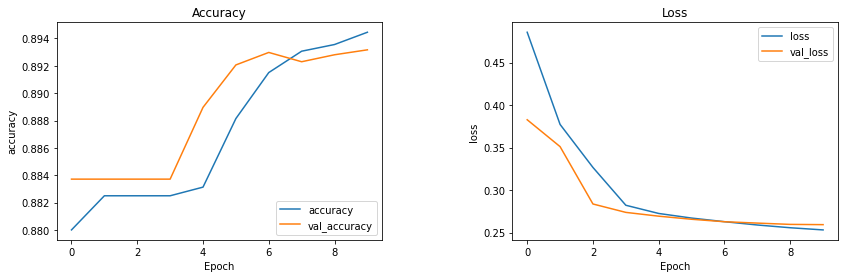

In [15]:
show_train_history(train_history)

In [17]:
testOverviewString = tokenizer.texts_to_sequences(["Hello world"])
print(testOverviewString)
testOverviewString = pad_sequences(testOverviewString, padding='post', maxlen=100)
print(testOverviewString)
predict = model.predict(testOverviewString)
print(predict)

[[5622, 90]]
[[5622   90    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
1/1 [==============================] - 2s 2s/step
[[0.01687672 0.98312336]]
